In [350]:
import numpy as np
from pydantic import BaseModel, Field, model_validator
from typing import List, Dict, Tuple, Literal, Optional

import matplotlib.pyplot as plt
import numpy as np

class CPMCellType(BaseModel):
    id: int = 0
    adhesion_energy: List[float] = Field([], description="List of Adhesion Energy between cell types. Must have an entry for each cell type in the simulation. Self-adhesion is ignored. First position (0) represents adhesion with the background / medium")
    preferred_volume: int = 9

class HamiltonianConstraint(BaseModel):
    """
        Represents an Hamiltonian term that imposes a constraint on the simulation
    """

    def delta(self, source, target, simulation_state: "CPMSimulation"):
        """
            Calculates the change in Hamiltonian energy (ΔH) for the target pixel 
            if the source pixel value were copied there.
        """
        # Initial adhesion energy at the target
        initial_energy = self.compute(source=source, target=target, simulation_state=simulation_state)

        # Simulate the copy operation (source -> target) to calculate potential new energy
        target_value = simulation_state.grid[target[0], target[1], 0]
        simulation_state.grid[target[0], target[1], 0] = simulation_state.grid[source[0], source[1], 0]
        new_energy = self.compute(source=source, target=target, simulation_state=simulation_state)

        # Reset the target pixel to its original state
        simulation_state.grid[target[0], target[1], 0] = target_value

        return new_energy - initial_energy

class AdhesionConstraint(HamiltonianConstraint):
    """
        Pixels of the same cell will be constrained to stick together
    """

    def compute(self, source, target,  simulation_state: "CPMSimulation"):
        """
            Compute adhesion hamiltonian given a simulation state
        """

        # TODO: This does not work if celltypes are provided unsorted
        energy_matrix = np.stack([ct.adhesion_energy for ct in simulation_state.cell_types])

        total_energy = 0
        grid=simulation_state.grid
        
        #for x in range(grid.shape[0]):
        #    for y in range(grid.shape[0]):
        #mask = simulation_state._difference_mask(grid=grid, z_value=1)
        #mask_coords = list(zip(*np.where(mask)))

        # Only check source and target neighbors
        source_neighbors = simulation_state._moore_neighborhood(*source)
        target_neighbors = simulation_state._moore_neighborhood(*target)

        for x, y in source_neighbors + target_neighbors:
            neighbors_coords = simulation_state._moore_neighborhood(x, y)
            source_celltype = grid[x, y, 1].astype(np.int32)
            for nx, ny in neighbors_coords:
                target_celltype = grid[nx, ny, 1].astype(np.int32)
                if source_celltype != target_celltype:
                    #print(f"{x=} {y=} {nx=} {ny=}")
                    # print(f"{x, y} vs {nx, ny}")
                    total_energy += energy_matrix[source_celltype, target_celltype]
        return total_energy

class VolumeConstraint(HamiltonianConstraint):
    def compute(self, source, target,  simulation_state: "CPMSimulation"):
        source_cell_id = simulation_state.grid[source][0].astype(np.int32)
        source_cell_type = simulation_state.grid[source][1].astype(np.int32)
        target_cell_id = simulation_state.grid[target][0].astype(np.int32)
        target_cell_type = simulation_state.grid[target][1].astype(np.int32)

        total_energy = 0

        if source_cell_type != 0:
            source_pref_volume = simulation_state.cell_types[source_cell_type].preferred_volume
            # FIXME: This is faster but approximate because it also counts the case a cell has splitted somehow
            # However, in case a cell split it should be assigned a new id so an appropriate check has to be made
            source_current_volume = np.sum(np.where(simulation_state.grid[..., 0] == source_cell_id, 1.0, 0.0))
            # TODO: Add lambda_volume
            total_energy += np.power(source_current_volume - source_pref_volume, 2)
        if target_cell_type != 0:
            target_pref_volume = simulation_state.cell_types[target_cell_type].preferred_volume
            # FIXME: This is faster but approximate because it also counts the case a cell has splitted somehow
            # However, in case a cell split it should be assigned a new id so an appropriate check has to be made
            target_current_volume = np.sum(np.where(simulation_state.grid[..., 0] == target_cell_id, 1.0, 0.0))
            # TODO: Add lambda_volume
            total_energy += np.power(target_current_volume - target_pref_volume, 2)

        return total_energy


class CPMSimulation(BaseModel):
    """
        Represents a lattice in which the cells live.

        It is encoded as a 3-channel image, encoded as following:
        0: Cell ID
        1: Cell Type ID
        2: Subcellular Entities (e.g. 0 is Nothing, 1 is Cytoplasm, 2 is the Nucleus)
    """
    grid_size: int
    grid: np.ndarray
    dimensions: int = 3
    temperature: float = Field(1.0, description="Temperature for the simulation. The higher the temperature, the more energetically unfavourable copy attempts will succeed.")
    neighborhood: Literal["moore"] = Field("moore", description="Which kind of neighborhood to check.")
    constraints: List[HamiltonianConstraint] = Field([AdhesionConstraint(), VolumeConstraint()])
    cell_types: List[CPMCellType]


    class Config:
        arbitrary_types_allowed = True

    def spawn_random_cell(self, n: int):
        """
            Spawn `n` random cells in the grid, assigning unique cell IDs.
            
            Parameters
            ----------
            n : int
                The number of cells to spawn.
        """
        # TODO: Consider placing the cytoplasm initially
        # Iterate over each cell to be spawned
        cell_types = [ct.id for ct in self.cell_types if ct.id != 0]
        for cell_id in range(1, n + 1):  # Start cell IDs from 1 since 0 is the background
            # Randomly select a position in the grid until an empty one is found
            while True:
                x, y = np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size)
                if self.grid[x, y, 0] == 0:  # Check if the cell ID layer at (x, y) is empty (background)
                    # Place the new cell
                    self.grid[x, y, 0] = cell_id  # Set cell ID
                    self.grid[x, y, 1] = np.random.choice(cell_types)
                    break  # Exit the loop once the cell is placed

    @model_validator(mode='before')
    def initialize_lattice(cls, values):
        grid_size = values.get("grid_size", 64)
        dimensions = values.get("dimensions", 3)
        if "grid" not in values:
            values["grid"] = np.zeros((grid_size, grid_size, dimensions))
        return values
    
    def get_random_pixel(self, mask=None) -> Tuple[Tuple[int, int], np.ndarray]:
        """
            Returns a random grid pixel.

            Parameters
            -------
            mask: ndarray, pick only from pixels that are inside this mask. If None, can pick any pixel.

            Returns
            -------
            coords: Tuple[int, int] - The coordinates of the sampled pixel
            value: np.ndarray - the slice of the grid corresponding to coords
        """
        if mask is not None:
            valid_coords = list(zip(*np.where(mask)))
            x, y = valid_coords[np.random.choice(len(valid_coords))]
        else:
            x = np.random.randint(0, self.grid_size)
            y = np.random.randint(0, self.grid_size)
        return (x, y), self.grid[x, y]

    def _moore_neighborhood(self, x: int, y: int) -> List[Tuple[int, int]]:
            """
                Generates the Moore neighborhood (8 neighbors) for a given pixel at (x, y).
                Ensures neighbors are within grid bounds.

                Parameters
                ----------
                x, y: int - Coordinates of the source pixel

                Returns
                -------
                neighbors: List[Tuple[int, int]] - List of coordinates for the Moore neighborhood
            """
            neighbors = []
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue  # Skip the source pixel itself
                    nx, ny = x + dx, y + dy
                    # Check boundaries to avoid edge errors
                    if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size:
                        neighbors.append((nx, ny))
            return neighbors

    def _difference_mask(self, grid, z_value=0) -> np.ndarray:
        """
        Creates a mask where pixels are marked as True if they have at least one neighbor with a different property (e.g., cell type or cell id).
        
        Parameters
        -------
        grid: the grid upon which computing the mask
        z_value: which layer to use

        Returns
        -------
        mask: np.ndarray - A 2D boolean array of the same width and height as the grid
        """
        height, width = grid.shape[:2]
        mask = np.zeros((height, width), dtype=bool)
        
        for x in range(width):
            for y in range(height):
                cell_property = grid[x, y, z_value]  # Get the cell property at (x, y)
                
                # Check neighbors
                for nx, ny in self._moore_neighborhood(x, y):
                    neighbor_cell_property = self.grid[nx, ny, z_value]
                    
                    # If there's a neighboring cell with a different property, mark this pixel in the mask
                    if cell_property != neighbor_cell_property:
                        mask[x, y] = True
                        break  # No need to check further neighbors
        
        return mask

    def get_random_neighbour(self, source_coords: Tuple[int, int], neighborhood="moore") -> Tuple[Tuple[int, int], np.ndarray]:
        """
            Returns a random neighbor of the source pixel based on the specified neighborhood.

            Parameters
            ----------
            source_coords: Tuple[int, int] - Coordinates of the source pixel
            neighborhood: str - The type of neighborhood ("moore" for 8 neighbors)

            Returns
            -------
            neighbor_coords: Tuple[int, int] - Coordinates of the randomly chosen neighbor
            neighbor_value: np.ndarray - The slice of the grid corresponding to the neighbor
        """
        x, y = source_coords
        if neighborhood == "moore":
            neighbors = self._moore_neighborhood(x, y)
        else:
            raise NotImplementedError("Unsupported neighborhood type. Only 'moore' is implemented.")
        
        if not neighbors:
            raise ValueError("No neighbors found, check lattice boundaries or neighborhood size.")
        
        # Pick a random neighbor
        neighbor_coords = neighbors[np.random.randint(len(neighbors))]
        return neighbor_coords, self.grid[neighbor_coords[0], neighbor_coords[1]]

    def get_pixel(self, coords: List[int]):
        return self.grid[coords, :]

    def copy_pixel(self, source, target):
        """
            Copy a pixel (and their other dimensions) from source coordinates to target coordinates.
        """
        #print(f"Copy {source} to {target}")
        self.grid[target] = self.grid[source]

    def render(self, plot_layer=1):
        """
            Renders the current state of the simulation grid.
            Each cell ID will be represented by a different color.
        """
        # Extract the cell ID layer (first layer) for rendering
        cell_id_layer = self.grid[:, :, plot_layer]

        # Define a color map; 'n' colors based on unique cell IDs
        unique_ids = np.unique(cell_id_layer)
        color_map = plt.cm.get_cmap("viridis", len(unique_ids))

        # Map each cell ID to a unique color index
        color_indices = np.searchsorted(unique_ids, cell_id_layer)

        # Plot the grid using the color indices
        plt.imshow(color_indices, cmap=color_map, origin="upper")
        plt.colorbar(label="Cell ID" if plot_layer == 0 else "Cell Type")
        plt.title("Cellular Potts Model Simulation")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

class CPM():
    def __init__(self, sim_config: CPMSimulation):
        self.sim = sim_config

    def metropolis(self):
        mask = self.sim._difference_mask(self.sim.grid, z_value=0) # Avoid picking from inside the cells or in the background
        mask_coord = list(zip(*np.where(mask)))
        np.random.shuffle(mask_coord)

        #for s_coord in range(self.sim.grid_size**2):
        for s_coord in mask_coord:
            #mask = self.sim._difference_mask(self.sim.grid, z_value=0) # Avoid picking from inside the cells or in the background

            # s_*: source t_*: target
            #s_coord, (s_cell, s_type, s_sub) = self.sim.get_random_pixel()
            s_cell = self.sim.grid[s_coord][0]
            t_coord, (t_cell, t_type, t_sub) = self.sim.get_random_neighbour(source_coords=s_coord)

            if s_cell == t_cell:
                continue
            
            # Copy attempt
            ## Compute Hamiltonian for each constraint
            total_delta_energy = 0
            for h in self.sim.constraints:
               total_delta_energy += h.delta(s_coord, t_coord, self.sim)
                        
            # Attempt outcome
            if total_delta_energy <= 0 or np.random.uniform() <= np.exp(-total_delta_energy/self.sim.temperature):
                self.sim.copy_pixel(source=s_coord, target=t_coord)


    def step(self, n=1):
        """ Perform n steps of Cellular Pott Model"""
        for n in range(n):
            print(f"{n=}")
            self.metropolis()

    def _render_animation(self):
        """
            Displays a widget to play the full animation
        """
        pass


/var/folders/6k/bmxrc4yx7qvcz0jxn0qwv6v00000gp/T/ipykernel_44235/3858420200.py:273: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("viridis", len(unique_ids))


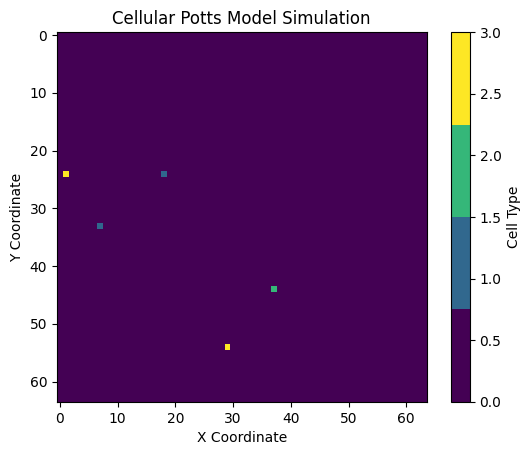

In [351]:
n_cell_types = 3

# Building adhesion matrix
adhesions = np.random.rand(n_cell_types, n_cell_types)
matrix = np.triu(adhesions, 1)
adhesions += adhesions.T
np.fill_diagonal(adhesions, 0)


# Cell Type definition (WARNING/TODO: LIST MUST BE ORDERED BY ID!)
cell_types = [
    CPMCellType(id=0, adhesion_energy=[0.0, 10.0, 10.0, 10.0]),
    CPMCellType(id=1, adhesion_energy=[10.0, 0.0, 5.0, 5.0]),
    CPMCellType(id=2, adhesion_energy=[10.0, 5.0, 0.0, 5.0]),
    CPMCellType(id=3, adhesion_energy=[10.0, 5.0, 5.0, 0.0]),
]

config = CPMSimulation(grid_size=64, temperature=0.5, cell_types=cell_types)
cpm = CPM(sim_config=config)
config.spawn_random_cell(5)
config.render(plot_layer=1)
# cpm.step()

In [352]:
cpm.step()
config.render()

n=0


AttributeError: module 'numpy' has no attribute 'pow'